# PyEddyTracker - EAC-003 QUIET ZONE ASSESSMENT
## CONTENTS;
### 1. Load in data
This notebook will be used to investigate what is happening in the EAC extension of EAC-003 in terms of mesoscale eddy features. 

The py-eddy-tracker seems to show eddies that move poleward from the separation region, before dissipating around 35-40S. I would like to animate, or at least plot interactively, the velocities coinciding with the eddy tracks to see whether this is indeed the case. 

In [2]:
from datetime import datetime

from matplotlib import pyplot as plt
from numpy import arange
import xarray as xr

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.eddy_feature import Contours

from py_eddy_tracker.observations.network import NetworkObservations
from py_eddy_tracker.observations.observation import EddiesObservations, Table
from py_eddy_tracker.observations.tracking import TrackEddiesObservations

import xarray as xr
import glob
from netCDF4 import Dataset
from datetime import timedelta

import cartopy.crs as ccrs
import cartopy.feature as feature

In [3]:
# set paths to model output
# adt_datapath = '/home/johnr/utas/Documents/phd_folder/gadi_notebooks/data/subsetted_data/'
adt_datapath = '/scratch/v45/jr5971/mom6-setonix/subsetted_data/'

## SRM
eac_003 = adt_datapath + 'eac-rg-dt.nc'
## LRM
sthpac_01 = adt_datapath + 'sthpac-rg-dt.nc'
## PARENT
om2_01 = adt_datapath + 'om2-rg-dt.nc' 
# OBS
aviso = adt_datapath + 'avisodt.nc'
# set paths to track files
aviso_track = adt_datapath + '/track_files/avisodt/'
eac_track = adt_datapath + '/track_files/eac-rg-dt/'
sthpac_track = adt_datapath + '/track_files/sthpac-rg-dt/'
om2_track = adt_datapath + '/track_files/om2-rg-dt/' 

### Open ssh files and plot
Load SSH Data 

In [4]:
plt.figure(figsize=(18,4))
aviso_ssh = xr.open_dataarray(aviso)
eac_ssh = xr.open_dataarray(eac_003)
sthpac_ssh = xr.open_dataarray(sthpac_01)
om2_ssh = xr.open_dataarray(om2_01)

# ssh_ls = [om2_ssh, sthpac_ssh, eac_ssh, aviso_ssh]

# for i, ssh in enumerate(ssh_ls):
#     plt.subplot(1,4,i+1)
#     ssh.isel(time=1000).plot()

<Figure size 1800x400 with 0 Axes>

**Plot EAC-003 Interactively**

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [6]:
def plot_eac_ssh(i):
    fig, ax = plt.subplots(figsize=(8,8))
    eac_ssh.isel(time=i).plot(ax=ax)

In [7]:
import ipywidgets
ipywidgets.__version__

'8.1.1'

In [8]:
interact(plot_eac_ssh, i=(0, len(eac_ssh.time), 1))

interactive(children=(IntSlider(value=1901, description='i', max=3803), Output()), _dom_classes=('widget-inter…

<function __main__.plot_eac_ssh(i)>

Okay so that's something else that's good to be aware of. The OM2 data start at Jan 1st, 1990, the STHPAC data start on Feb 1st, 1990 whilst the EAC data start the day after on Feb 2nd, 1990. 

This should impact anything too much though. 

Right so we've got these four datasets. All have been detrended, and the three model sources have been regridded to the AVISO grid. What's next to do? 

I'd like to make some plots of these, as well as the geostrophic velocities associated with the SLA's too. From those we could make some nice streamplots. 

# Track Eddies
NOTE - the "tracking" has already been computed on all datasets, so here we'll just load those in and start plotting!

#### Steps for tracking eddies

In [6]:
from py_eddy_tracker.data import get_remote_demo_sample
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances

In [6]:
# Get files of eddy detection
ac_eddy_files = glob.glob(adt_datapath+'id-eddies_eac-003-filtered-dask/AC*.nc'); ac_eddy_files.sort()
cc_eddy_files = glob.glob(adt_datapath+'id-eddies_eac-003-filtered-dask/CC*.nc'); cc_eddy_files.sort()
print(len(ac_eddy_files), len(cc_eddy_files))


3776 3776


In [7]:
%%time
# compute eddy tracks
ac_correspondances = Correspondances(datasets=ac_eddy_files, virtual=3)
cc_correspondances = Correspondances(datasets=cc_eddy_files, virtual=3)
# track eddies
ac_correspondances.track(); cc_correspondances.track()
ac_correspondances.prepare_merging(); cc_correspondances.prepare_merging()
# merge results
ac_eddytracks = ac_correspondances.merge(raw_data=False)
cc_eddytracks = cc_correspondances.merge(raw_data=False)
# capture virtual eddies required
ac_eddytracks.virtual[:] = ac_eddytracks.time==0
cc_eddytracks.virtual[:] = cc_eddytracks.time==0
# interpolate between virtual eddy tracks
ac_eddytracks.filled_by_interpolation(ac_eddytracks.virtual == 1)
cc_eddytracks.filled_by_interpolation(cc_eddytracks.virtual == 1)

High number of conflict : 4 (nb_conflict)
High number of conflict : 15 (nb_conflict)
High number of conflict : 6 (nb_conflict)
High number of conflict : 7 (nb_conflict)
High number of conflict : 6 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 10 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 7 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 11 (nb_conflict)
High number of conflict : 14 (nb_conflict)
High number of conflict : 15 (nb_conflict)
High number of conflict : 11 (nb_conflict)
High number of conflict : 11 (nb_conflict)
High number of conflict : 12 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 12 (nb_conflict)
High number of conflict :

CPU times: user 10min 3s, sys: 2min, total: 12min 3s
Wall time: 25min 30s


In [8]:
print(ac_eddytracks)

/mnt/c/Users/johnr/OneDrive - University of Tasmania/Documents/phd_folder/gadi_notebooks/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


    | 76152 observations from 14642 to 18444 (3803 days, ~20 obs/day)
    |   Speed area      : 0.16 Mkm²/day
    |   Effective area  : 0.29 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.94     17.80     12.21      9.21      7.02     24.67     28.15
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.59     17.29     32.96     21.51     13.40     10.26      3.97      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.16      8.00     16.49     19.34     19.07     21.83     15.12      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00  

In [9]:
print(cc_eddytracks)

    | 84814 observations from 14642 to 18444 (3803 days, ~22 obs/day)
    |   Speed area      : 0.16 Mkm²/day
    |   Effective area  : 0.25 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       1.09     20.42     14.58     11.42      8.12     24.78     19.58
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       2.20     22.60     29.15     22.07     12.84      7.99      3.16      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.77     11.29     20.09     22.64     19.16     17.39      8.66      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00  

Okay so now I've got these eddy tracks. Let's just work through a few of the examples to get a feel for how to play around with the data.

### Load tracking results and start plotting!
Here we use `extract_with_length` to extract eddies with tracks of a particular length. 
* `extract_with_length`: Return the observations within trajectories lasting between [b0:b1]
   * **NOTE: This is length in "days" not in distance!**

In [9]:
aviso_ac = TrackEddiesObservations.load_file(aviso_track + 'Anticyclonic.nc')
aviso_cc = TrackEddiesObservations.load_file(aviso_track + 'Cyclonic.nc')

model_tracks = dict()
for name, path in zip(['eac', 'sthpac', 'om2'], [eac_track, sthpac_track, om2_track]):
    model_tracks[name] = {'ac':TrackEddiesObservations.load_file(path+'Anticyclonic.nc'), 
                          'cc':TrackEddiesObservations.load_file(path+'Cyclonic.nc')}
    

**Display tracking in time**

In [ ]:
def track_in_time(i):
    fig = plt.figure()
    ax = fig.add_axes((0.05, 0.05, 0.9, 0.9))
    ax.set_xlim(aviso_ac['eac'].lon

In [8]:
model_tracks['eac']

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


{'ac':     | 113473 observations from 14642 to 18444 (3803 days, ~30 obs/day)
     |   Speed area      : 0.25 Mkm²/day
     |   Effective area  : 0.35 Mkm²/day
     ----Distribution in Amplitude:
     |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
     |   Percent of eddies         :       0.82     19.12     16.21     11.90      8.20     24.44     19.31
     ----Distribution in Radius:
     |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
     |   Percent of eddies         :       0.00      8.94     40.21     24.18     12.50      9.20      4.97      0.01
     |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
     |   Percent of eddies         :       0.00      6.06     28.01     22.84     16.60     16.05     10.42      0.02
     ----Distribution in Latitude
         Latitude bounds          

Okay, well that's a pretty neat way of loading in the different datasets. Now we have a single object for the ac and cc aviso tracks, and a dictionary holding the ac/cc tracks for each of the three model outputs. Now there's various choices when it comes to plotting all this data, e.g., 
* Temporal range
* Eddy radii
* Amplitude
* Cyclonic or Anticyclonic

Whilst there's also the choice of how to plot the different datasets together. 

I think it might be best to first just plot eddy characteristics on the unfiltered datasets, then we can filter certain length-scales or eddy life length afterwards. 

In [9]:
step=0.1

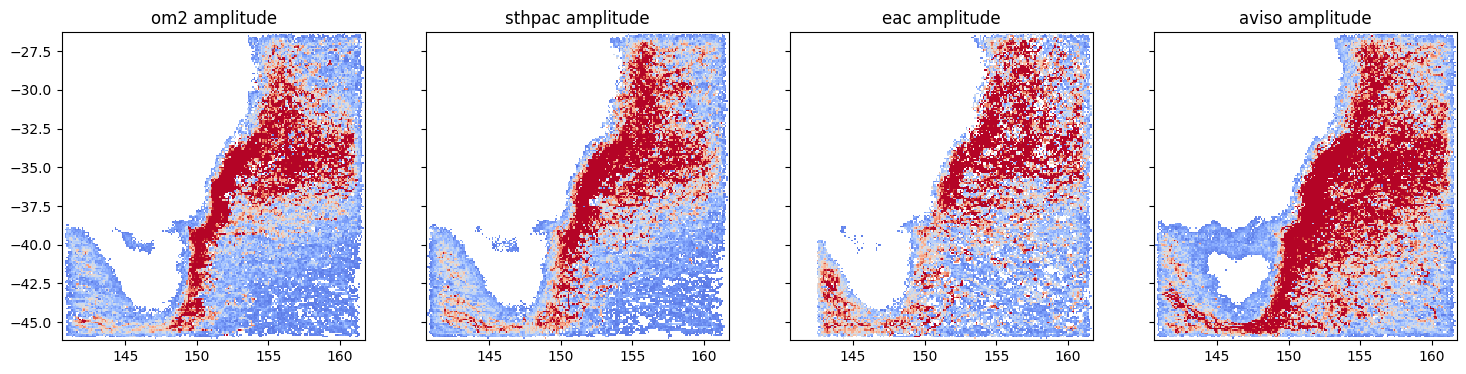

In [11]:
# Plot AC amplitudes of all data over four subplots
## get the coord bounds for taking the pixel averages
coord_bounds = {'W':aviso_ssh.longitude.min().values, 'E':aviso_ssh.longitude.max().values,
                'S':aviso_ssh.latitude.min().values, 'N':aviso_ssh.latitude.max().values}

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18,4))

# plot aviso amplitudes
g1 = aviso_ac.grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         varname='amplitude')
m1 = g1.display(axs[-1], name='amplitude', vmin=0, vmax=10, factor=100)
axs[3].set_title('aviso amplitude')

for i, model_name in enumerate(['om2','sthpac', 'eac']):
    g = model_tracks[model_name]['ac'].grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         varname='amplitude')
    m = g.display(axs[i], name='amplitude', vmin=0, vmax=10, factor=100)
    axs[i].set_title(f'{model_name} amplitude')


In [13]:
model_tracks['aviso'] = {'ac':aviso_ac, 'cc':aviso_cc}

So, the above is quite interesting, and to some extent further supports the "concerns" about the EAC-003 not performing great in the extension region, especially when you look at the observational data. What does this figure show? It shows the amplitudes of eddies in the region. It's extremely interesting to see this, regardless of whether it's showing what we'd hoped or not. Also interesting that both OM2 and SOUTHPAC extend all the way to the left, but EAC doesn't. Why is this? What's the minimum longitude of eac? 

Okay so this is where I got to; And it turns out that the bounds chosen for this subsetted region fall outside the bounds of the eac-003 domain. Options: just add an xlim to all maps?

Let's plot something that shows similar to the above but for the different track lengths. So we have a perhaps 4x4 grid

In [21]:
for i, [l, u] in enumerate(zip(lower, upper)):
    print(i, l, u)

0 0 50
1 50 100
2 100 200
3 200 300
4 300 -1


In [19]:
for l, u in zip(lower, upper):
    print(l, u)

0 50
50 100
100 200
200 300
300 -1


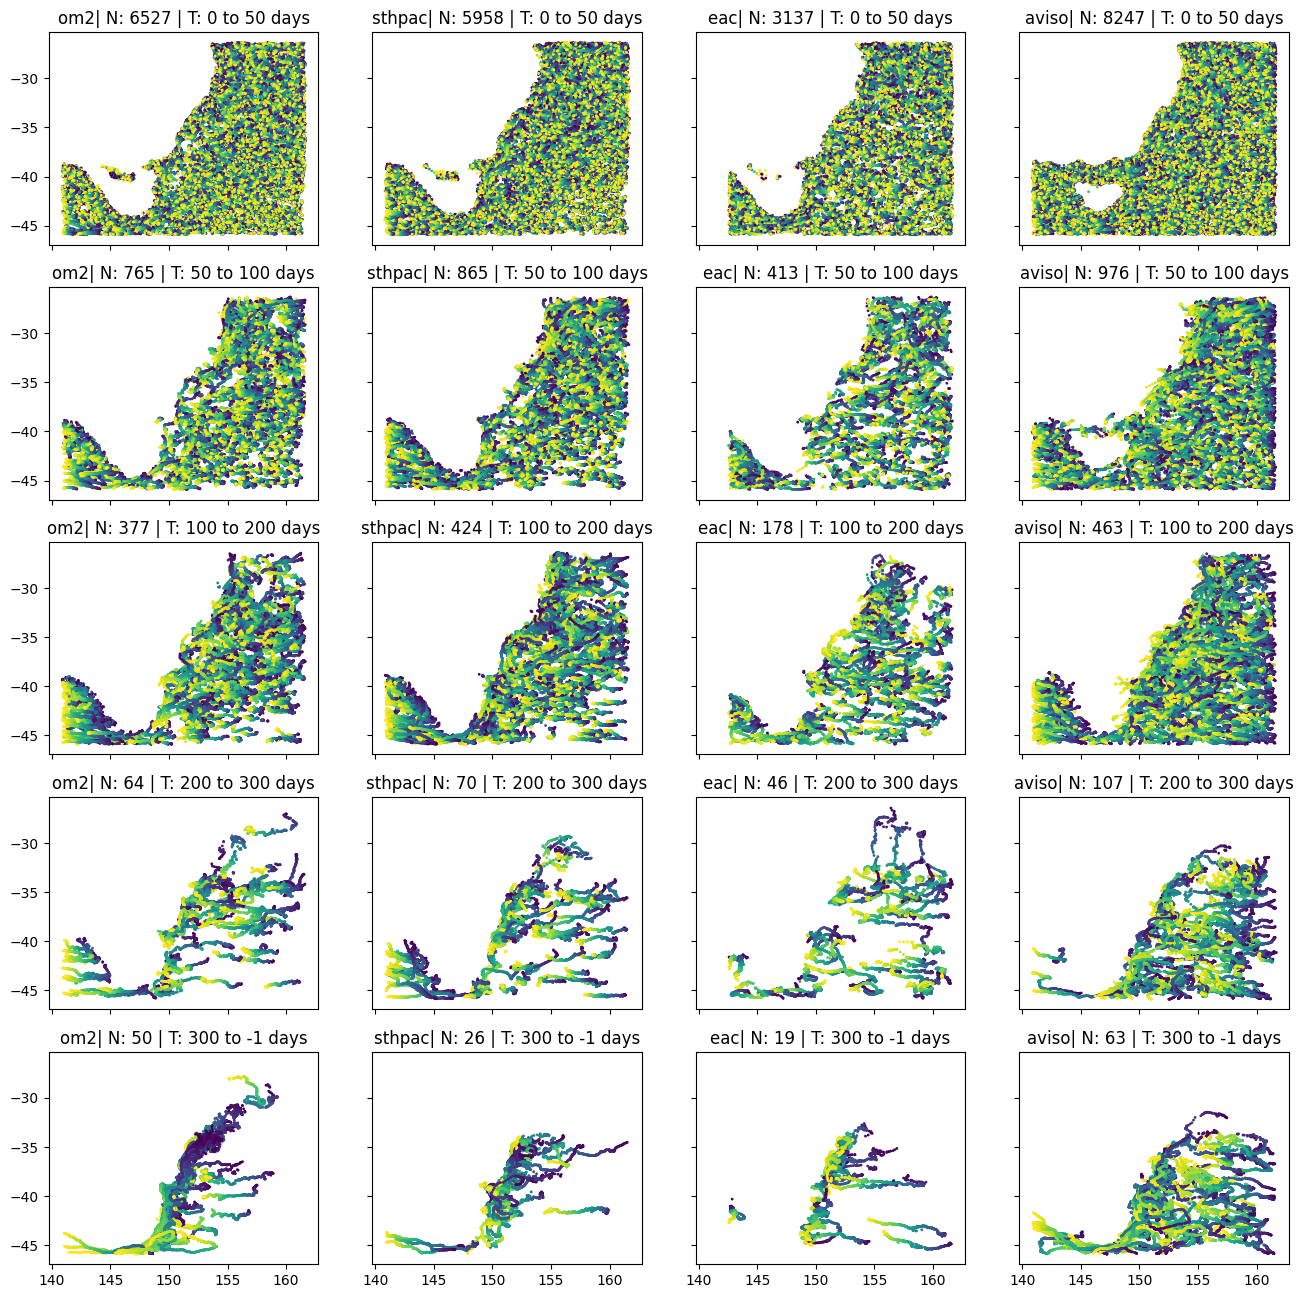

In [34]:
lower = [0, 50, 100, 200, 300]
upper = [50, 100, 200, 300, -1]

fig, axs = plt.subplots(5,4, figsize=(16,16), sharex=True, sharey=True)
# loop through each track-length range as the rows of the subplots
for i, [l, u] in enumerate(zip(lower, upper)):
    # loop through each dataset for each of the different track-lengths
    for j, model_name in enumerate(['om2','sthpac', 'eac','aviso']):
        # select the ac tracks for each individual dataset
        ac_track = model_tracks[model_name]['ac']
        # filter the tracks by the given lower and upper bounds
        ac_track_filt = ac_track.extract_with_length((l,u))
        axs[i,j].set_title(f'{model_name}| N: {ac_track_filt.nb_tracks} | T: {l} to {u} days')
        m = ac_track_filt.scatter(axs[i,j], 'age', ref=-10, s=1)
        
        
    

Text(0.5, 0.98, 'Amplitudes averaged by 0.1 degree box')

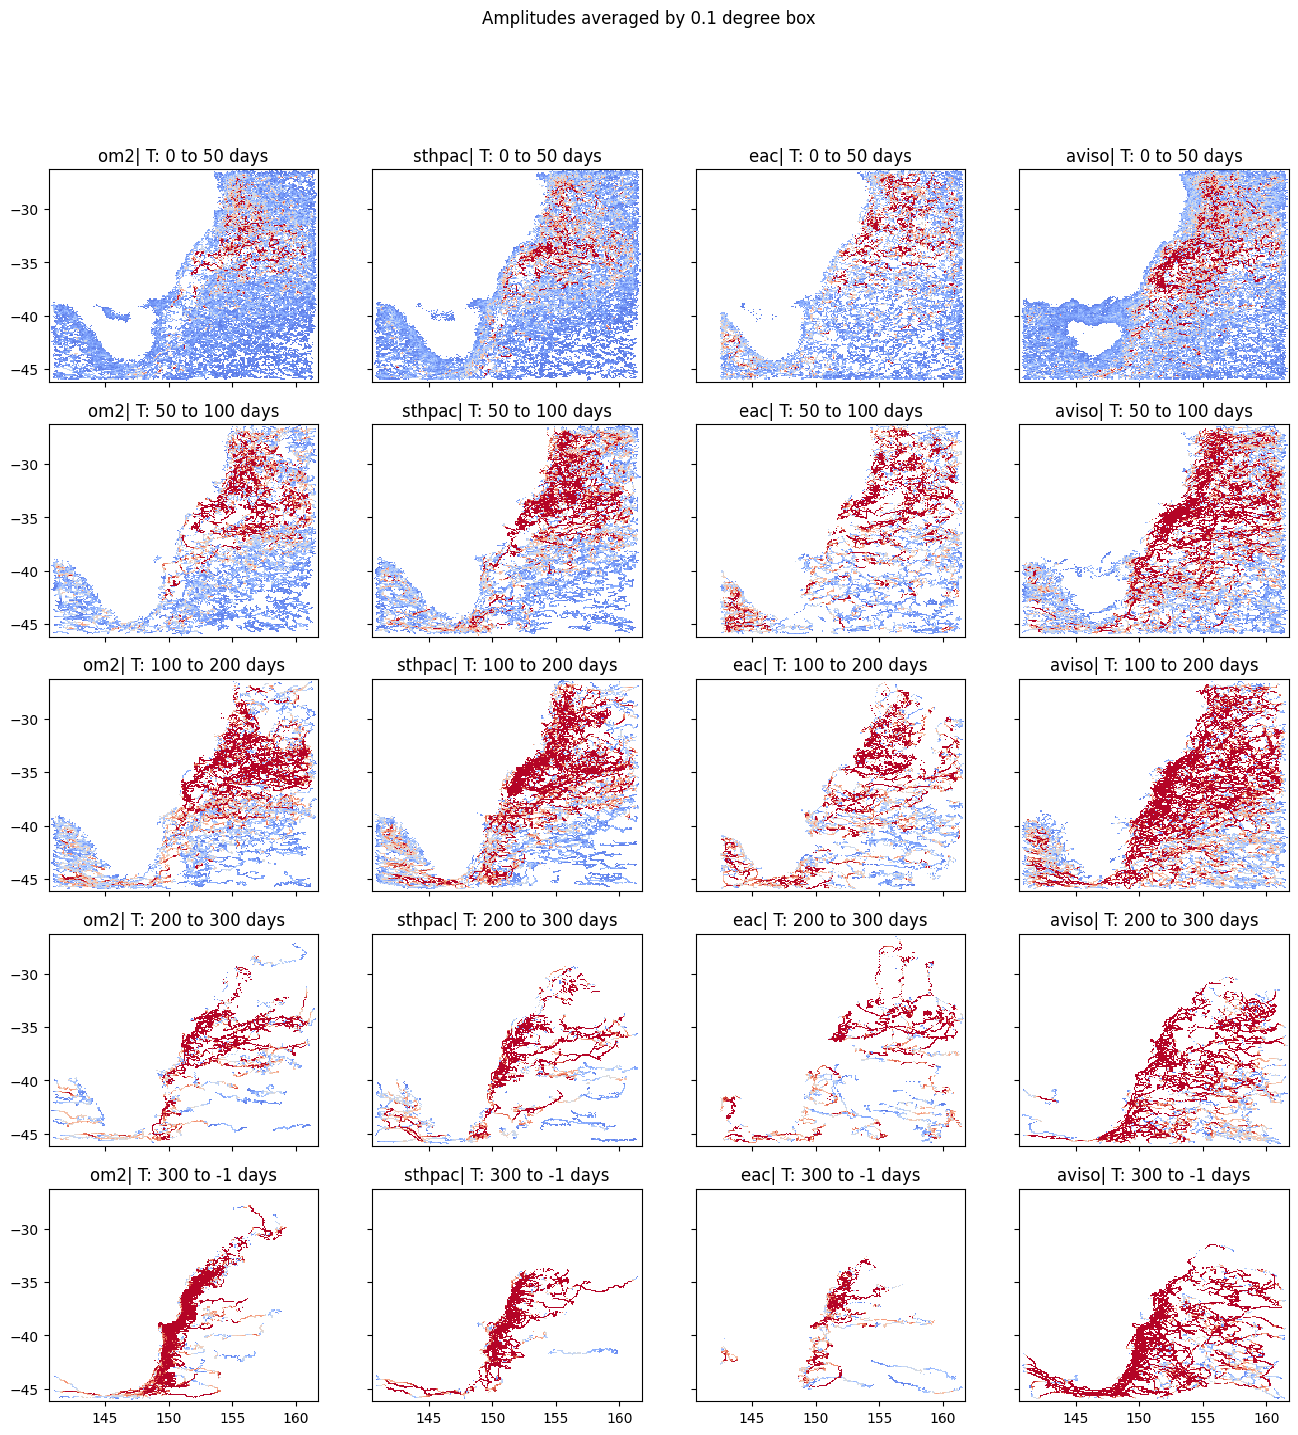

In [33]:
# PLOT AMPLITUDES AVERAGED OVER GRID-BOXES
lower = [0, 50, 100, 200, 300]
upper = [50, 100, 200, 300, -1]

fig, axs = plt.subplots(5,4, figsize=(16,16), sharex=True, sharey=True)
# loop through each track-length range as the rows of the subplots
for i, [l, u] in enumerate(zip(lower, upper)):
    # loop through each dataset for each of the different track-lengths
    for j, model_name in enumerate(['om2','sthpac', 'eac','aviso']):
        # select the ac tracks for each individual dataset
        ac_track = model_tracks[model_name]['ac']
        # filter the tracks by the given lower and upper bounds
        ac_track_filt = ac_track.extract_with_length((l,u))
        axs[i,j].set_title(f'{model_name}| T: {l} to {u} days')
        g = ac_track_filt.grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                                    (coord_bounds['S'], coord_bounds['N'], step)),
                                    varname='amplitude')
        m = g.display(axs[i,j], name='amplitude', vmin=0, vmax=10, factor=100)
        
fig.suptitle('Amplitudes averaged by 0.1 degree box')
    

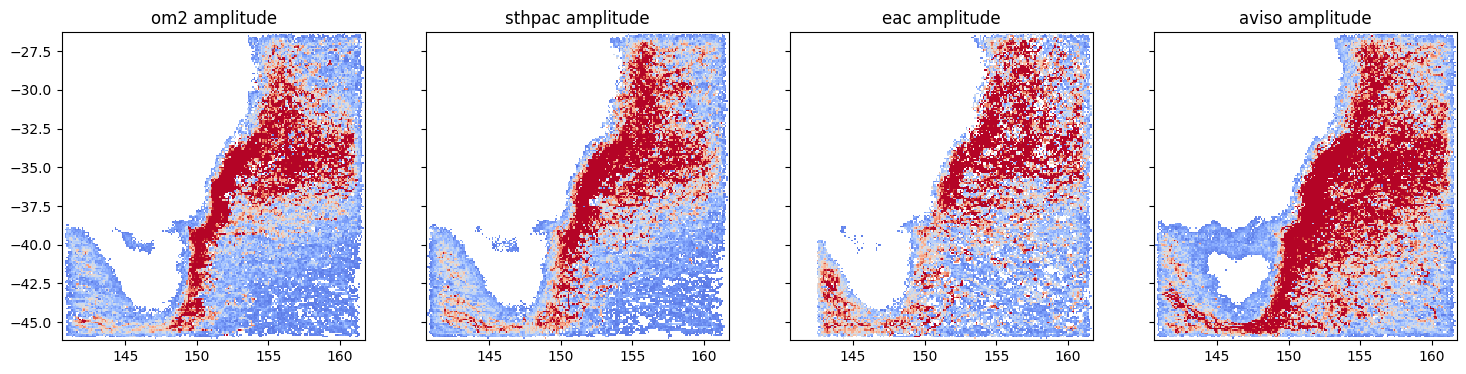

In [11]:
# Plot AC amplitudes of all data over four subplots
## get the coord bounds for taking the pixel averages
coord_bounds = {'W':aviso_ssh.longitude.min().values, 'E':aviso_ssh.longitude.max().values,
                'S':aviso_ssh.latitude.min().values, 'N':aviso_ssh.latitude.max().values}

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18,4))

# plot aviso amplitudes
g1 = aviso_ac.grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         varname='amplitude')
m1 = g1.display(axs[-1], name='amplitude', vmin=0, vmax=10, factor=100)
axs[3].set_title('aviso amplitude')

for i, model_name in enumerate(['om2','sthpac', 'eac']):
    g = model_tracks[model_name]['ac'].grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         varname='amplitude')
    m = g.display(axs[i], name='amplitude', vmin=0, vmax=10, factor=100)
    axs[i].set_title(f'{model_name} amplitude')


Knowing what the breakdown looks like for the different lenghts of tracks, the above unfiltered summary gives a pretty decent picture overall. It might be worth keeping this for a potential poster picture. 

### Tracks which go through area
Here we use another new method called `position_filter`. This seems to a filter based on the `loess` algorithm, standing for "locally estimated scatterplot smoothing" - chatGPT refers to this as a *"weighted scatterplot smoothing algorithm. It's a non-parameteric method used for smoothing noisy data by fitting a low-degree polynomial to localised subsets of the data"*. 

**Here's the example provided in chatGPT**

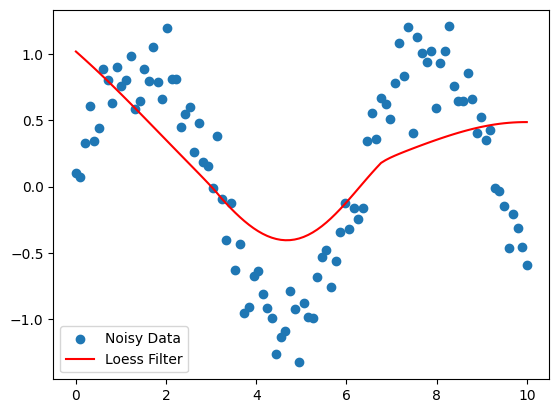

In [45]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Generate some noisy data
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.2, size=len(x))

# Apply a loess filter using statsmodels
lowess_result = sm.nonparametric.lowess(y, x)

# Plot the original data and the smoothed curve
plt.scatter(x, y, label='Noisy Data')
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', label='Loess Filter')
plt.legend()
plt.show()


Okay that gives a pretty good idea of what we might expect this method to do. Let's go ahead and use this `position_filter`

In [49]:
cc_filt = cc_eddytracks.copy()
ac_filt = ac_eddytracks.copy()
cc_filt.position_filter(median_half_window=1, loess_half_window=5)
ac_filt.position_filter(median_half_window=1, loess_half_window=5)

We extract eddies in the area set below, but we ask to keep `full_path`

In [50]:
x0, x1, y0, y1 = 155, 158, -30, -28
area = dict(llcrnrlon=x0, llcrnrlat=y0, urcrnrlon=x1, urcrnrlat=y1)
cc_withinbox = cc_filt.extract_with_area(area, full_path=True)
ac_withinbox = ac_filt.extract_with_area(area, full_path=True)

#### Plot

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)


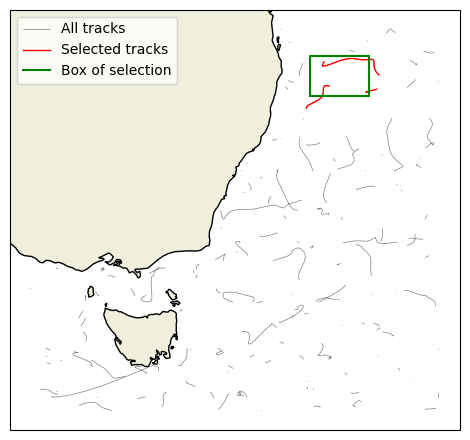

In [52]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes((0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
cc_filt.plot(ax, color='grey', lw=0.5, ref=-10, label="All tracks", transform=ccrs.PlateCarree())
cc_withinbox.plot(
    ax, color='r', lw=1, ref=-10, label='Selected tracks', transform=ccrs.PlateCarree())
ax.add_feature(feature.LAND)
ax.coastlines()
ax.grid()
ax.plot(
    (x0, x0, x1, x1, x0),
    (y0, y1, y1, y0, y0),
    color='g',
    lw=1.5,
    label='Box of selection'
)
ax.legend()

This again is a pretty cool feature and will come in handy and look more interesting when combined with the 'extract_with_length' method as well as longer timeseries.

### One Track
Using the `extract_longer_eddies` method, we determine a threshold whereby 

In [60]:
eddy = ac_eddytracks.extract_with_length((100,-1))
eddy

| 600 observations from 15706 to 15805 (100 days, ~6 obs/day)
    |   Speed area      : 0.09 Mkm²/day
    |   Effective area  : 0.13 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.00      1.50      4.33     11.17      2.33     21.17     59.50
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.17      7.83     39.17     17.00     18.00     17.83      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.17      2.17      5.33     18.00     43.33     31.00      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00    100.00      0.00      0.00      0.00
        Percent of speed area     :       0.00    100.00      0.00      0.00      0.00
        Percent of effective area :       0.00    100.00      0.00      0.00      0.00
        Mean speed radius (km)    :        nan     70.77       nan       nan       nan
        Mean effective radius (km):        nan     88.50       nan       nan       nan
        Mean amplitude (cm)       :        nan     11.69       nan       nan       nan
    | 6 tracks (100.00 obs/tracks, shorter 100 obs, longer 100 obs)
    |   4 filled observations (0.67 obs/tracks, 0.67 % of total)
    |   Intepolated speed area      : 0.00 Mkm²/day
    |   Intepolated effective area  : 0.00 Mkm²/day
    |   Distance by day             : Mean 2.47 , Median 2.23 km/day
    |   Distance by track           : Mean 254.64 , Median 235.41 km/track
    ----Distribution in lifetime:
    |   Lifetime (days  )            1.00     30.00     90.00    180.00    270.00    365.00   1000.00  10000.00
    |   Percent of tracks         :       0.00      0.00    100.00      0.00      0.00      0.00      0.00
    |   Percent of eddies         :       0.00      0.00    100.00      0.00      0.00      0.00      0.00

In [65]:
# filter
eddy.position_filter(median_half_window=1, loess_half_window=5)

In [81]:
kw_ax = dict(rect=(0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
def start_axes(title):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes(**kw_ax)
    ax.set_title(title, weight='bold')
    ax.add_feature(feature.LAND)
    ax.coastlines()
    return ax
def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))
    

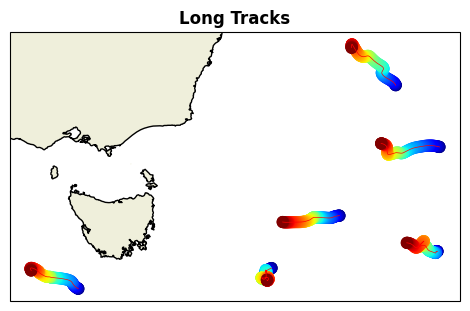

In [82]:
# Plot
ax = start_axes('Long Tracks')
eddy.plot(ax, color='r', lw=0.5)
eddy.scatter(ax, 'n', cmap='jet', s=60)
update_axes(ax)

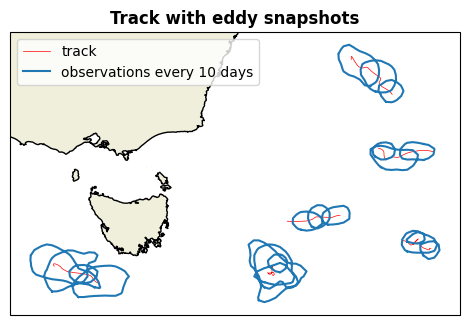

In [85]:
# Plot track with shape snapshots
ax = start_axes('Track with eddy snapshots')
eddy.plot(ax, color='r', lw=0.5, label='track')
eddy.index(range(0, len(eddy), 30)).display(
    ax, intern_only=True, label="observations every 10 days")
ax.legend()

That index method is a good trick - select only particular timesteps of an eddies track

### Display Tracks

In [87]:
# keep eddies longer than 20 weeks
ac_long = ac_eddytracks.extract_with_length((7*10, -1))
cc_long = cc_eddytracks.extract_with_length((7*10, -1))
print(ac_long)
print(cc_long)

    | 942 observations from 15706 to 15805 (100 days, ~9 obs/day)
    |   Speed area      : 0.13 Mkm²/day
    |   Effective area  : 0.20 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.00      5.52     14.44     13.91      2.87     16.35     46.92
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.53     13.69     35.56     17.09     17.41     15.71      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.42      5.31     14.65     20.17     31.21     28.24      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -1

Position filter for nicer display

In [88]:
ac_long.position_filter(median_half_window=1, loess_half_window=5)
cc_long.position_filter(median_half_window=1, loess_half_window=5)

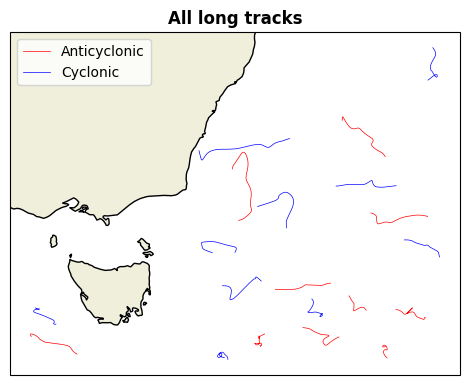

In [89]:
# Plot
ax = start_axes('All long tracks')
ac_long.plot(ax, ref=-10, label="Anticyclonic", color='r', lw=0.5)
cc_long.plot(ax, ref=-10, label="Cyclonic", color='b', lw=0.5)
ax.legend()
ax.grid()

## Tracking Diagnostics
### Geographical Statistics

In [ ]:
# Merge ac and cc
eddies_merged = ac_eddytracks.merge(cc_eddytracks)
step = 0.1

Mean of amplitude in each box

In [104]:
coord_bounds = {'W':adt_aviso.longitude.min().values, 'E':adt_aviso.longitude.max().values,
                'S':adt_aviso.latitude.min().values, 'N':adt_aviso.latitude.max().values}

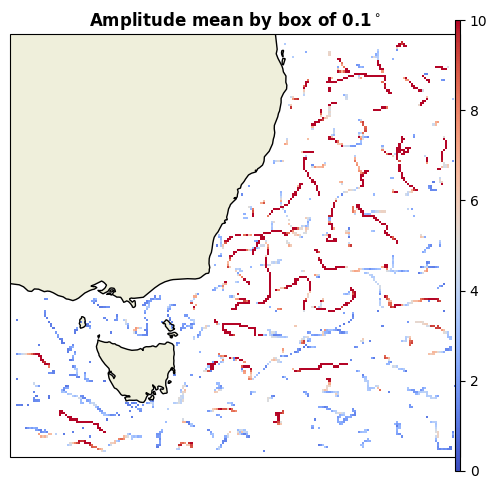

In [107]:
ax = start_axes("Amplitude mean by box of %s$^\circ$" % step)
g = eddies_merged.grid_stat(((coord_bounds['W'], coord_bounds['E'], step), 
                            (coord_bounds['S'], coord_bounds['N'], step)), 
                            varname='amplitude')
m = g.display(ax, name='amplitude', vmin=0, vmax=10, factor=100)
ax.grid()
update_axes(ax, m)

Okay, so once we have a lot of data, these ***Eulerian*** methods of visualising and diagnosing the eddy metrics will be really useful and interesting. We can then compare these maps between datasets.

Mean of speed radius in each box